Background Information

Question: We aim to investigate whether data science techniques can denote countries sharing similar characteristics in terms of both food prices and nutritional value indices via a xgBoost ML model.

Signifcance: This research question addresses global challenges related to nutrition, food security, and sustainable development. The outcomes have the potential to guide the formulation of evidence-based policies, promoting better access to nutritious food and enhancing the well-being of the world.

Background: The Food Prices for Nutrition database integrates data from the International Comparison Program, food composition databases, and diverse nutritional sources, offering a comprehensive perspective on healthy diet economics across 176 countries from 2017-2021. Through our research, we decided to choose the variable "Percent of the population who cannot afford a healthy diet [CoHD_headcount]" as our target variable in order to assess the likelihood of food scarcity in specific nations. This metric serves as a key indicator for addressing global challenges related to nutrition accessibility and affordability. When finding our initial dataset on World Bank, we noticed that many countries lacked data after 2017, which could be due to the state that country is in and potentially the lack of data on more specific/obscure variables. To address this, we added 11 columns of more straightforward variables (also from World Bank), such as percentage of population under the poverty line. In doing this we aim to create a more accurate model due to these variables lower amount of NAs. Additionally all of the variables, original and later added ones, were selected due to their perceived relevance to the issue that we are aiming to address and have some sort of tie to lack of proper diet.

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report


In [2]:
Food_data = pd.read_csv(r"/Users/alexandratorti/DS PROJECT COURSE/food_data1.csv",encoding="latin")

In this section, we read multiple recent CSV files covering the years 2017 to 2021, encompassing diverse data related to income distribution, food production, poverty, undernourishment, low birth weight, crop production, and current healthcare expenditure. This decision was influenced by valuable feedback received from groups yesterday, which highlighted the limitations of our initial dataset in fully exploring and answering our research questions. To address these limitations, we opted to enhance our dataset by incorporating additional sources of information. 

The melt function is applied to each dataset, transforming it from a wide to a long format. This process involves converting columns into rows and creating new columns for the melted variables (Year and Value). The id_vars parameter specifies which columns to retain as identifier variables, while var_name and value_name set the names for the new columns. Columns that are not needed for further analysis, such as 'Classification Name, 'Classification Code, and 'Time Code', are dropped from each melted DataFrame.The final merged DataFrame (merged_df) is obtained, containing a consolidated set of variables from all the initially separate datasets.

In this section, we read multiple recent CSV files covering the years 2017 to 2021, encompassing diverse data related to income distribution, food production, poverty, undernourishment, low birth weight, crop production, and current healthcare expenditure. This decision was influenced by valuable feedback received from groups yesterday, which highlighted the limitations of our initial dataset in fully exploring and answering our research questions. To address these limitations, we opted to enhance our dataset by incorporating additional sources of information. 

In [3]:
## 1. Income Share by Top

import pandas as pd
top_df = pd.read_csv(r"/Users/alexandratorti/DS PROJECT COURSE/Income share by top 10%.csv")
df_top = pd.melt(top_df, id_vars=['Country Name', 'Country Code', 'Series Name', "Series Code"], var_name='Year', value_name='Income share held by highest 10%')
columns_to_drop = ['Country Code', 'Series Name', 'Series Code']
df_top = df_top.drop(columns=columns_to_drop) 
df_top.head()

,Country Name,Year,Income share held by highest 10%
0,Afghanistan,2017 [YR2017],..
1,Albania,2017 [YR2017],24.6
2,Algeria,2017 [YR2017],..
3,American Samoa,2017 [YR2017],..
4,Andorra,2017 [YR2017],..


In [4]:
## 2. Food production Index

import pandas as pd
foodp_df = pd.read_csv(r"/Users/alexandratorti/DS PROJECT COURSE/Food production index.csv")
df_fp = pd.melt(foodp_df, id_vars=['Country Name', 'Country Code', 'Series Name', "Series Code"], var_name='Year', value_name='Food production index (2014-2016 = 100)')
df_fp = df_fp.drop(columns=columns_to_drop)
df_fp.head()

,Country Name,Year,Food production index (2014-2016 = 100)
0,Afghanistan,2017 [YR2017],100.02
1,Albania,2017 [YR2017],103.9
2,Algeria,2017 [YR2017],102.87
3,American Samoa,2017 [YR2017],..
4,Andorra,2017 [YR2017],..


In [5]:
## 3. Income share by lowest 10

import pandas as pd
low_df = pd.read_csv(r"/Users/alexandratorti/DS PROJECT COURSE/Income share by lowest 10%.csv")
df_low = pd.melt(low_df, id_vars=['Country Name', 'Country Code', 'Series Name', "Series Code"], var_name='Year', value_name='Income share held by lowest 10%')
df_low = df_low.drop(columns=columns_to_drop)
df_low.head()

,Country Name,Year,Income share held by lowest 10%
0,Afghanistan,2017 [YR2017],..
1,Albania,2017 [YR2017],3.1
2,Algeria,2017 [YR2017],..
3,American Samoa,2017 [YR2017],..
4,Andorra,2017 [YR2017],..


In [6]:
## 4. Poverty Line

import pandas as pd

poverty_line_df = pd.read_csv(r"/Users/alexandratorti/DS PROJECT COURSE/Poverty line.csv")
df_poverty_line = pd.melt(poverty_line_df, id_vars=['Country Name', 'Country Code', 'Series Name', "Series Code"], var_name='Year', value_name = 'Poverty headcount ratio at national poverty lines (% of population)')
df_poverty_line = df_poverty_line.drop(columns=columns_to_drop)#
df_poverty_line.head()

,Country Name,Year,Poverty headcount ratio at national poverty lines (% of population)
0,Afghanistan,2017 [YR2017],..
1,Albania,2017 [YR2017],23.4
2,Algeria,2017 [YR2017],..
3,American Samoa,2017 [YR2017],..
4,Andorra,2017 [YR2017],..


In [7]:
## 5. Prevalence of Undernourishment

import pandas as pd
undernourishment_df = pd.read_csv(r"/Users/alexandratorti/DS PROJECT COURSE/Prevalence of undernourishment.csv")
df_undernourishment = pd.melt(undernourishment_df, id_vars=['Country Name', 'Country Code', 'Series Name', "Series Code"], var_name='Year', value_name='Prevalence of undernourishment (% of population)')
df_undernourishment = df_undernourishment.drop(columns=columns_to_drop)
df_undernourishment.head()


,Country Name,Year,Prevalence of undernourishment (% of population)
0,Afghanistan,2017 [YR2017],22.7
1,Albania,2017 [YR2017],4.2
2,Algeria,2017 [YR2017],2.6
3,American Samoa,2017 [YR2017],..
4,Andorra,2017 [YR2017],..


In [8]:
## 6. Low Birth Weight of Babies

import pandas as pd
low_birth_weight_df = pd.read_csv(r"/Users/alexandratorti/DS PROJECT COURSE/low birth weight babies.csv")
df_low_birth_weight = pd.melt(low_birth_weight_df, id_vars=['Country Name', 'Country Code', 'Series Name', "Series Code"], var_name='Year', value_name='Low-birthweight babies (% of births)')
df_low_birth_weight = df_low_birth_weight.drop(columns=columns_to_drop)
df_low_birth_weight.head()


,Country Name,Year,Low-birthweight babies (% of births)
0,Afghanistan,2017 [YR2017],..
1,Albania,2017 [YR2017],5.944848467
2,Algeria,2017 [YR2017],7.087203761
3,American Samoa,2017 [YR2017],..
4,Andorra,2017 [YR2017],9.310531252


In [9]:
## 7. Proportion of people living under median income

import pandas as pd
umedian_df = pd.read_csv(r"/Users/alexandratorti/DS PROJECT COURSE/Proportion of people living under median income.csv")
df_umedian = pd.melt(umedian_df, id_vars=['Country Name', 'Country Code', 'Series Name', "Series Code"], var_name='Year', value_name='Proportion of people living below 50 percent of median income (%)')
df_umedian = df_umedian.drop(columns=columns_to_drop)
df_umedian.head()

,Country Name,Year,Proportion of people living below 50 percent of median income (%)
0,Afghanistan,2017 [YR2017],..
1,Albania,2017 [YR2017],11.7
2,Algeria,2017 [YR2017],..
3,American Samoa,2017 [YR2017],..
4,Andorra,2017 [YR2017],..


In [10]:
## 8. Current Healthcare expenditure 

import pandas as pd
che_df = pd.read_csv(r"/Users/alexandratorti/DS PROJECT COURSE/Current Healthcare expenditure.csv")
df_che = pd.melt(che_df, id_vars=['Country Name', 'Country Code', 'Series Name', "Series Code"], var_name='Year', value_name='Current health expenditure (% of GDP)')
df_che = df_che.drop(columns=columns_to_drop)
df_che.head()

,Country Name,Year,Current health expenditure (% of GDP)
0,Afghanistan,2017 [YR2017],12.62081718
1,Albania,2017 [YR2017],6.54604626
2,Algeria,2017 [YR2017],6.27938414
3,American Samoa,2017 [YR2017],..
4,Andorra,2017 [YR2017],7.16179609


In [11]:
## 9. Crop Production 

import pandas as pd
crop_df = pd.read_csv(r"/Users/alexandratorti/DS PROJECT COURSE/Crop production.csv")
df_crop = pd.melt(crop_df, id_vars=['Country Name', 'Country Code', 'Series Name', "Series Code"], var_name='Year', value_name='Crop production index (2014-2016 = 100)')
df_crop = df_crop.drop(columns=columns_to_drop)
df_crop.head()

,Country Name,Year,Crop production index (2014-2016 = 100)
0,Afghanistan,2017 [YR2017],99.69
1,Albania,2017 [YR2017],105.84
2,Algeria,2017 [YR2017],104.4
3,American Samoa,2017 [YR2017],..
4,Andorra,2017 [YR2017],..


The cell below merges several DataFrames (`df_top`, `df_fp`, `df_low`, `df_poverty_line`, `df_undernourishment`, `df_low_birth_weight`, `df_umedian`, `df_che`, and `df_crop`) into a consolidated DataFrame named `merged_df`. The merging process is performed based on common columns ('Country Name' and 'Year'). This integration of DataFrames aims to create a comprehensive dataset that combines information from various aspects that could contribute to our target variable and original dataset

In [12]:
#now its time to merge all our new data frames
# Merge DataFrames
merged_df = pd.merge(df_top, df_fp, on=['Country Name', 'Year'])
merged_df = pd.merge(merged_df, df_low, on=['Country Name', 'Year'])
merged_df = pd.merge(merged_df, df_poverty_line, on=['Country Name', 'Year'])
merged_df = pd.merge(merged_df, df_undernourishment, on=['Country Name', 'Year'])
merged_df = pd.merge(merged_df, df_low_birth_weight, on=['Country Name', 'Year'])
merged_df = pd.merge(merged_df, df_umedian, on=['Country Name', 'Year'])
merged_df = pd.merge(merged_df, df_che, on=['Country Name', 'Year'])
merged_df = pd.merge(merged_df, df_crop, on=['Country Name', 'Year'])
merged_df.head()

,Country Name,Year,Income share held by highest 10%,Food production index (2014-2016 = 100),Income share held by lowest 10%,Poverty headcount ratio at national poverty lines (% of population),Prevalence of undernourishment (% of population),Low-birthweight babies (% of births),Proportion of people living below 50 percent of median income (%),Current health expenditure (% of GDP),Crop production index (2014-2016 = 100)
0,Afghanistan,2017 [YR2017],..,100.02,..,..,22.7,..,..,12.62081718,99.69
1,Albania,2017 [YR2017],24.6,103.9,3.1,23.4,4.2,5.944848467,11.7,6.54604626,105.84
2,Algeria,2017 [YR2017],..,102.87,..,..,2.6,7.087203761,..,6.27938414,104.4
3,American Samoa,2017 [YR2017],..,..,..,..,..,..,..,..,..
4,Andorra,2017 [YR2017],..,..,..,..,..,9.310531252,..,7.16179609,..


In [13]:
# Fix the year variables to match the main dataset
merged_df['Year'] = merged_df['Year'].str.extract(r'(\d{4})', expand=False)
merged_df.head()

,Country Name,Year,Income share held by highest 10%,Food production index (2014-2016 = 100),Income share held by lowest 10%,Poverty headcount ratio at national poverty lines (% of population),Prevalence of undernourishment (% of population),Low-birthweight babies (% of births),Proportion of people living below 50 percent of median income (%),Current health expenditure (% of GDP),Crop production index (2014-2016 = 100)
0,Afghanistan,2017,..,100.02,..,..,22.7,..,..,12.62081718,99.69
1,Albania,2017,24.6,103.9,3.1,23.4,4.2,5.944848467,11.7,6.54604626,105.84
2,Algeria,2017,..,102.87,..,..,2.6,7.087203761,..,6.27938414,104.4
3,American Samoa,2017,..,..,..,..,..,..,..,..,..
4,Andorra,2017,..,..,..,..,..,9.310531252,..,7.16179609,..


In [14]:
# rename Time column on food_data to Year
Food_data.rename(columns={'Time': 'Year'}, inplace=True)

Food_data.head()


,Classification Name,Classification Code,Country Name,Country Code,Year,Time Code,Cost of an energy sufficient diet [CoCA],Cost of a nutrient adequate diet [CoNA],Cost of a healthy diet [CoHD],Cost of a healthy diet relative to the cost of sufficient energy from starchy staples [CoHD_CoCA],...,Affordability of an energy sufficient diet: ratio of cost to food expenditures [CoCA_fexp],Affordability of a nutrient adequate diet: ratio of cost to food expenditures [CoNA_fexp],Affordability of a healthy diet: ratio of cost to food expenditures [CoHD_fexp],Percent of the population who cannot afford sufficient calories [CoCA_headcount],Percent of the population who cannot afford nutrient adequacy [CoNA_headcount],Percent of the population who cannot afford a healthy diet [CoHD_headcount],Millions of people who cannot afford sufficient calories [CoCA_unafford_n],Millions of people who cannot afford nutrient adequacy [CoNA_unafford_n],Millions of people who cannot afford a healthy diet [CoHD_unafford_n],Population [Pop]
0,Food Prices for Nutrition 2.1,FPN 2.1,Albania,ALB,2017,YR2017,0.725,2.471,3.952,5.45,...,0.078,0.266,0.425,0,8.9,31.3,0,0.3,0.9,2873457
1,Food Prices for Nutrition 2.1,FPN 2.1,Albania,ALB,2018,YR2018,..,..,4.069,..,...,..,..,..,..,..,23,..,..,0.7,2866376
2,Food Prices for Nutrition 2.1,FPN 2.1,Albania,ALB,2019,YR2019,..,..,4.262,..,...,..,..,..,..,..,22.2,..,..,0.6,2854191
3,Food Prices for Nutrition 2.1,FPN 2.1,Albania,ALB,2020,YR2020,..,..,4.28,..,...,..,..,..,..,..,19.9,..,..,0.6,2837849
4,Food Prices for Nutrition 2.1,FPN 2.1,Albania,ALB,2021,YR2021,..,..,4.388,..,...,..,..,..,..,..,15.7,..,..,0.4,2811666


In [15]:
# Convert year to integer 
Food_data['Year'] = pd.to_numeric(Food_data['Year'], errors='coerce')
Food_data['Year'] = Food_data['Year'].fillna(0).astype(int)

Food_data.head()

,Classification Name,Classification Code,Country Name,Country Code,Year,Time Code,Cost of an energy sufficient diet [CoCA],Cost of a nutrient adequate diet [CoNA],Cost of a healthy diet [CoHD],Cost of a healthy diet relative to the cost of sufficient energy from starchy staples [CoHD_CoCA],...,Affordability of an energy sufficient diet: ratio of cost to food expenditures [CoCA_fexp],Affordability of a nutrient adequate diet: ratio of cost to food expenditures [CoNA_fexp],Affordability of a healthy diet: ratio of cost to food expenditures [CoHD_fexp],Percent of the population who cannot afford sufficient calories [CoCA_headcount],Percent of the population who cannot afford nutrient adequacy [CoNA_headcount],Percent of the population who cannot afford a healthy diet [CoHD_headcount],Millions of people who cannot afford sufficient calories [CoCA_unafford_n],Millions of people who cannot afford nutrient adequacy [CoNA_unafford_n],Millions of people who cannot afford a healthy diet [CoHD_unafford_n],Population [Pop]
0,Food Prices for Nutrition 2.1,FPN 2.1,Albania,ALB,2017,YR2017,0.725,2.471,3.952,5.45,...,0.078,0.266,0.425,0,8.9,31.3,0,0.3,0.9,2873457
1,Food Prices for Nutrition 2.1,FPN 2.1,Albania,ALB,2018,YR2018,..,..,4.069,..,...,..,..,..,..,..,23,..,..,0.7,2866376
2,Food Prices for Nutrition 2.1,FPN 2.1,Albania,ALB,2019,YR2019,..,..,4.262,..,...,..,..,..,..,..,22.2,..,..,0.6,2854191
3,Food Prices for Nutrition 2.1,FPN 2.1,Albania,ALB,2020,YR2020,..,..,4.28,..,...,..,..,..,..,..,19.9,..,..,0.6,2837849
4,Food Prices for Nutrition 2.1,FPN 2.1,Albania,ALB,2021,YR2021,..,..,4.388,..,...,..,..,..,..,..,15.7,..,..,0.4,2811666


In [16]:
# Convert an integer column to string 
Food_data['Year'] = Food_data['Year'].astype(str)

Food_data.head()

,Classification Name,Classification Code,Country Name,Country Code,Year,Time Code,Cost of an energy sufficient diet [CoCA],Cost of a nutrient adequate diet [CoNA],Cost of a healthy diet [CoHD],Cost of a healthy diet relative to the cost of sufficient energy from starchy staples [CoHD_CoCA],...,Affordability of an energy sufficient diet: ratio of cost to food expenditures [CoCA_fexp],Affordability of a nutrient adequate diet: ratio of cost to food expenditures [CoNA_fexp],Affordability of a healthy diet: ratio of cost to food expenditures [CoHD_fexp],Percent of the population who cannot afford sufficient calories [CoCA_headcount],Percent of the population who cannot afford nutrient adequacy [CoNA_headcount],Percent of the population who cannot afford a healthy diet [CoHD_headcount],Millions of people who cannot afford sufficient calories [CoCA_unafford_n],Millions of people who cannot afford nutrient adequacy [CoNA_unafford_n],Millions of people who cannot afford a healthy diet [CoHD_unafford_n],Population [Pop]
0,Food Prices for Nutrition 2.1,FPN 2.1,Albania,ALB,2017,YR2017,0.725,2.471,3.952,5.45,...,0.078,0.266,0.425,0,8.9,31.3,0,0.3,0.9,2873457
1,Food Prices for Nutrition 2.1,FPN 2.1,Albania,ALB,2018,YR2018,..,..,4.069,..,...,..,..,..,..,..,23,..,..,0.7,2866376
2,Food Prices for Nutrition 2.1,FPN 2.1,Albania,ALB,2019,YR2019,..,..,4.262,..,...,..,..,..,..,..,22.2,..,..,0.6,2854191
3,Food Prices for Nutrition 2.1,FPN 2.1,Albania,ALB,2020,YR2020,..,..,4.28,..,...,..,..,..,..,..,19.9,..,..,0.6,2837849
4,Food Prices for Nutrition 2.1,FPN 2.1,Albania,ALB,2021,YR2021,..,..,4.388,..,...,..,..,..,..,..,15.7,..,..,0.4,2811666


In [17]:
# Merge with original dataset
merged_df = pd.merge(Food_data, merged_df, on=['Country Name', 'Year'])

merged_df.head()

,Classification Name,Classification Code,Country Name,Country Code,Year,Time Code,Cost of an energy sufficient diet [CoCA],Cost of a nutrient adequate diet [CoNA],Cost of a healthy diet [CoHD],Cost of a healthy diet relative to the cost of sufficient energy from starchy staples [CoHD_CoCA],...,Population [Pop],Income share held by highest 10%,Food production index (2014-2016 = 100),Income share held by lowest 10%,Poverty headcount ratio at national poverty lines (% of population),Prevalence of undernourishment (% of population),Low-birthweight babies (% of births),Proportion of people living below 50 percent of median income (%),Current health expenditure (% of GDP),Crop production index (2014-2016 = 100)
0,Food Prices for Nutrition 2.1,FPN 2.1,Albania,ALB,2017,YR2017,0.725,2.471,3.952,5.45,...,2873457,24.6,103.9,3.1,23.4,4.2,5.944848467,11.7,6.54604626,105.84
1,Food Prices for Nutrition 2.1,FPN 2.1,Albania,ALB,2018,YR2018,..,..,4.069,..,...,2866376,22.7,106.08,3.2,23,4.1,5.950160932,11.8,6.65958786,106.2
2,Food Prices for Nutrition 2.1,FPN 2.1,Albania,ALB,2019,YR2019,..,..,4.262,..,...,2854191,23.6,104.11,3.5,21.8,4.1,5.966775754,8.6,..,107.76
3,Food Prices for Nutrition 2.1,FPN 2.1,Albania,ALB,2020,YR2020,..,..,4.28,..,...,2837849,22.8,105.77,3.4,22,4.1,5.992350456,9.6,..,114.12
4,Food Prices for Nutrition 2.1,FPN 2.1,Albania,ALB,2021,YR2021,..,..,4.388,..,...,2811666,..,103.44,..,..,4.1,..,..,..,114.75


In [18]:
#Drop columns that are not needed
columns_to_drop = ['Classification Name', 'Classification Code', 'Classification Code', 'Time Code',]
df_food = merged_df.drop(columns=columns_to_drop)
df_food.head() 

,Country Name,Country Code,Year,Cost of an energy sufficient diet [CoCA],Cost of a nutrient adequate diet [CoNA],Cost of a healthy diet [CoHD],Cost of a healthy diet relative to the cost of sufficient energy from starchy staples [CoHD_CoCA],Cost of fruits [CoHD_f],Cost of vegetables [CoHD_v],Cost of starchy staples [CoHD_ss],...,Population [Pop],Income share held by highest 10%,Food production index (2014-2016 = 100),Income share held by lowest 10%,Poverty headcount ratio at national poverty lines (% of population),Prevalence of undernourishment (% of population),Low-birthweight babies (% of births),Proportion of people living below 50 percent of median income (%),Current health expenditure (% of GDP),Crop production index (2014-2016 = 100)
0,Albania,ALB,2017,0.725,2.471,3.952,5.45,0.911,0.707,0.599,...,2873457,24.6,103.9,3.1,23.4,4.2,5.944848467,11.7,6.54604626,105.84
1,Albania,ALB,2018,..,..,4.069,..,..,..,..,...,2866376,22.7,106.08,3.2,23,4.1,5.950160932,11.8,6.65958786,106.2
2,Albania,ALB,2019,..,..,4.262,..,..,..,..,...,2854191,23.6,104.11,3.5,21.8,4.1,5.966775754,8.6,..,107.76
3,Albania,ALB,2020,..,..,4.28,..,..,..,..,...,2837849,22.8,105.77,3.4,22,4.1,5.992350456,9.6,..,114.12
4,Albania,ALB,2021,..,..,4.388,..,..,..,..,...,2811666,..,103.44,..,..,4.1,..,..,..,114.75


In [19]:
#Need to drop .. values so that we can transform values to floats
df_food.replace('..', np.nan, inplace=True)
df_food.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 46 columns):
 #   Column                                                                                                      Non-Null Count  Dtype 
---  ------                                                                                                      --------------  ----- 
 0   Country Name                                                                                                830 non-null    object
 1   Country Code                                                                                                830 non-null    object
 2   Year                                                                                                        830 non-null    object
 3   Cost of an energy sufficient diet [CoCA]                                                                    166 non-null    object
 4   Cost of a nutrient adequate diet [CoNA]                                   

In [20]:
#We need to change the columns that are objects to strings and floats
columns_to_convert = df_food.columns[3:46]
df_food[columns_to_convert] = df_food[columns_to_convert].apply(pd.to_numeric, errors='coerce')


columns_to_convert2 = df_food.columns[0:2]
df_food[columns_to_convert2] = df_food[columns_to_convert2].astype(str)
df_food.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 46 columns):
 #   Column                                                                                                      Non-Null Count  Dtype  
---  ------                                                                                                      --------------  -----  
 0   Country Name                                                                                                830 non-null    object 
 1   Country Code                                                                                                830 non-null    object 
 2   Year                                                                                                        830 non-null    object 
 3   Cost of an energy sufficient diet [CoCA]                                                                    166 non-null    float64
 4   Cost of a nutrient adequate diet [CoNA]                             

In [21]:
# Group by the 'country' column and calculate the total number of NaN values for each country
nan_counts_per_country = df_food.groupby('Country Name').apply(lambda x: x.isnull().sum()).sum(axis=1)

# Replace 'nutrition_variable_column' with the actual name of the column you're interested in
column_of_interest = 'Percent of the population who cannot afford a healthy diet [CoHD_headcount]'

# Calculate the total number of NaN values for each country in the specified column
nan_counts_per_country = df_food.groupby('Country Name')[column_of_interest].apply(lambda x: x.isnull().sum())

# Create a new DataFrame with country names and their corresponding NaN counts for the specified column
nan_counts_df = pd.DataFrame({'Country Name': nan_counts_per_country.index, 'NaN_Counts': nan_counts_per_country.values})

# Sort the DataFrame based on NaN counts in descending order
sorted_nan_counts_df = nan_counts_df.sort_values(by='NaN_Counts', ascending=False)

# Display the DataFrame with NaN counts per country for the specified column
print(sorted_nan_counts_df.head(50))

# Get the list of countries with 5 or more NaN values
countries_to_drop = nan_counts_df[nan_counts_df['NaN_Counts'] >= 5]['Country Name']

# Drop rows with the specified countries from the original DataFrame
df_filtered = df_food[~df_food['Country Name'].isin(countries_to_drop)]

# Display the filtered DataFrame
print(df_filtered)

                       Country Name  NaN_Counts
146  St. Vincent and the Grenadines           5
30                         Cambodia           5
33                   Cayman Islands           5
25                Brunei Darussalam           5
24           British Virgin Islands           5
71             Hong Kong SAR, China           5
113                     New Zealand           5
39                          Comoros           5
138       Sint Maarten (Dutch part)           5
154                            Togo           5
18                          Bermuda           5
137                       Singapore           5
44                          Curacao           5
157        Turks and Caicos Islands           5
65                          Grenada           5
13                         Barbados           5
132                    Saudi Arabia           5
11                          Bahrain           5
10                     Bahamas, The           5
48                         Dominica     

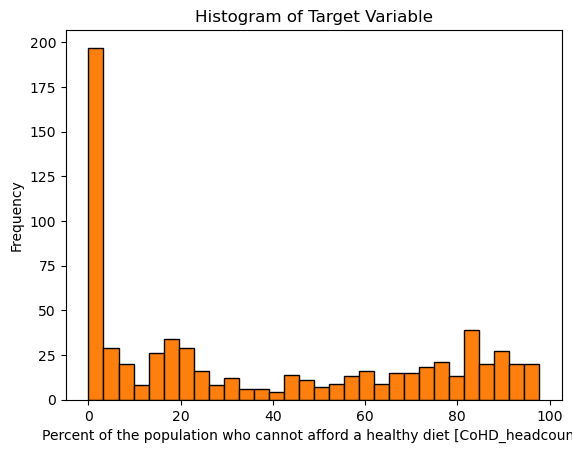

In [51]:
#Lets look at the distribution of the target variable

#Histogram
plt.hist(df_filtered['Percent of the population who cannot afford a healthy diet [CoHD_headcount]'], bins=30, edgecolor='black', color='#ff7f0e')
plt.title('Histogram of Target Variable')
plt.xlabel('Percent of the population who cannot afford a healthy diet [CoHD_headcount]')
plt.ylabel('Frequency')
plt.show()
# looks like a lot of entries have low percentages of populations that cant afford healthy food. lets look at the lowest countries

In [23]:
#There seems to be a lot of values at 0, lets see which countries fall in this bin. 
# Group by country and calculate statistics for the target variable
grouped_data = df_filtered.groupby('Country Name')['Percent of the population who cannot afford a healthy diet [CoHD_headcount]'].describe()
# Display the countries with the most values in the first bin
countries_in_first_bin = grouped_data[grouped_data['25%'] <= df_filtered['Percent of the population who cannot afford a healthy diet [CoHD_headcount]'].min()]
print(countries_in_first_bin)
#These countries have very high development indexes and thus would have very low values of percent of the population who cannot afford a healthy diet

              count  mean       std  min  25%  50%  75%  max
Country Name                                                
Azerbaijan      5.0  0.00  0.000000  0.0  0.0  0.0  0.0  0.0
Iceland         5.0  0.00  0.000000  0.0  0.0  0.0  0.0  0.0
Luxembourg      5.0  0.18  0.204939  0.0  0.0  0.1  0.4  0.4
Slovenia        5.0  0.06  0.054772  0.0  0.0  0.1  0.1  0.1
Switzerland     5.0  0.00  0.000000  0.0  0.0  0.0  0.0  0.0


Axes(0.125,0.11;0.775x0.77)


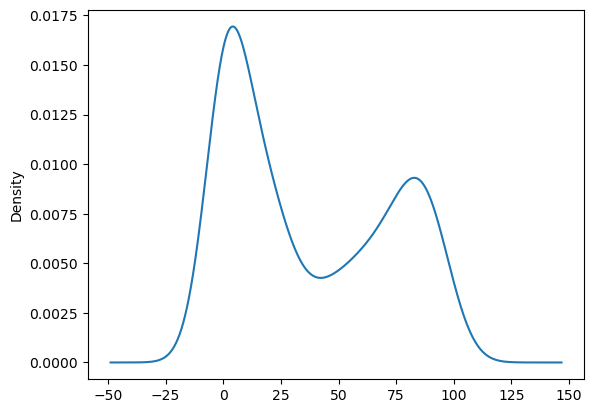

In [24]:
# Density plot
print(df_filtered['Percent of the population who cannot afford a healthy diet [CoHD_headcount]'].plot.density())

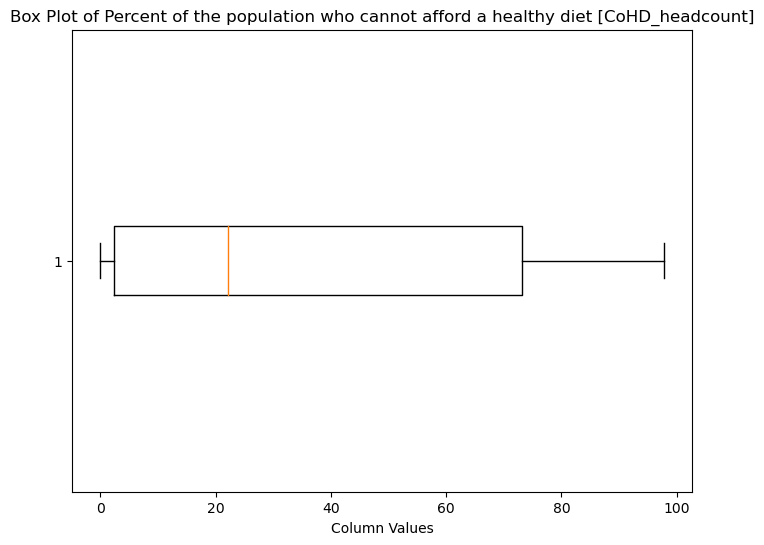

Median: 22.2
Maximum: 97.8


In [58]:
# created a boxplot to find the median and max to see how we should bin the data

column_to_plot = 'Percent of the population who cannot afford a healthy diet [CoHD_headcount]'

plt.figure(figsize=(8, 6))
plt.boxplot(df_filtered[column_to_plot].dropna(), vert=False)
plt.title(f'Box Plot of {column_to_plot}')
plt.xlabel('Column Values')
median_value = df_filtered[column_to_plot].median()
max_value = df_filtered[column_to_plot].max()

plt.show()

print(f"Median: {median_value}")
print(f"Maximum: {max_value}")


#df_filtered = df_filtered.loc[df_filtered['Percent of the population who cannot afford a healthy diet [CoHD_headcount]']< 80,:]  


In [56]:
#add this as a predictor instead of replacing the numeric version
# this predictor indicates the countries that have a high percentage of people who cant afford a healthy diet as a 1 and those who dont as a 0
df_filtered['CoHD_category'] = pd.cut(df_food['Percent of the population who cannot afford a healthy diet [CoHD_headcount]'], bins=[-1, 16.1, 79.8], labels=[0, 1])
#said that countries that are a concern are above median


# Perform one-hot encoding
df_filtered2 = pd.get_dummies(df_filtered, columns=["CoHD_category"], prefix="CoHD")
 #True if 1, False if 0
df_filtered2 = df_filtered2.drop(columns=['CoHD_0'])


/var/folders/55/4w5l1r5x0618j7pxmq4kdgmr0000gn/T/ipykernel_38360/3708128075.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['CoHD_category'] = pd.cut(df_food['Percent of the population who cannot afford a healthy diet [CoHD_headcount]'], bins=[-1, 16.1, 79.8], labels=[0, 1])


Given the extent of NaN values in our data, we chose to use an xgBoost ML model (gradient boosting algorithms). XGBoost is like a bunch of little decision trees working together to make predictions. Each tree splits your data into groups based on what features best helps guess the outcome. 
XGBoost belongs to the family of gradient boosting algorithms, which build a series of weak learners (typically decision trees)sequentially, where each tree corrects the errors made by the previous ones.

In [27]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import warnings


# warnings.simplefilter(action='ignore', category=FutureWarning)

# target_variable = 'CoHD_category'

# # Select only numeric columns
# numeric_df = df_filtered.select_dtypes(include=['float64', 'int64'])

# # Compute the correlation matrix
# correlation_matrix = numeric_df.corr()

# # Visualize the correlation matrix using a heatmap
# plt.figure(figsize=(12, 10))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
# plt.title('Correlation Matrix')
# plt.show()

# # Focus on the correlation of other variables with the target variable
# target_correlations = correlation_matrix[target_variable].sort_values(ascending=False)
# print(f'Correlations with {target_variable}:\n{target_correlations}')


In [28]:
#given the high amount of correlation between some of the columns which help calculate the the target variable, we will remove these columns.

# Drop multiple columns
columns_to_drop = ['Percent of the population who cannot afford nutrient adequacy [CoNA_headcount]', 'Percent of the population who cannot afford nutrient adequacy [CoNA_headcount]', 'Millions of people who cannot afford a healthy diet [CoHD_unafford_n]']
df_filtered2 = df_filtered2.drop(columns=columns_to_drop)

In [29]:
#Lets try XGBOOST
#we established our target variables as a categorical variable
target_variable = 'CoHD_1'

In [30]:

# Extract the target variable (y)
y = df_filtered2[target_variable]

X = df_filtered2.drop(columns=[target_variable, 'Country Name', 'Country Code', 'Year'])

# Check for missing values in y
if y.isnull().any():
    # If y contains NaN values, handle them (for example, by removing rows with NaN in y)
    df = df_filtered2.dropna(subset=[target_variable])
    y = df[target_variable]
    X = df.drop(columns=['Percent of the population who cannot afford a healthy diet [CoHD_headcount]', 'Country Name', 'Country Code'])
# Extract the independent variables (X)
    
# Clean up feature names to allow for parsing
X.columns = [col.replace('[', '').replace(']', '').replace('<', '') for col in X.columns]
X = X.drop(columns = ['Percent of the population who cannot afford a healthy diet CoHD_headcount']) #too much correlation with this variable so must remove


In [31]:
# Concatenate X and y to form a new DataFrame
df_combined = pd.concat([X, y], axis=1)

# Calculate the correlation matrix
correlation_matrix = df_combined.corr()

# Display the correlation between the target variable and other variables
target_correlations = correlation_matrix['CoHD_1'].sort_values(ascending=False)
print(target_correlations)


CoHD_1                                                                                                      1.000000
Income share held by highest 10%                                                                            0.441386
Cost of oils and fats CoHD_of                                                                               0.325707
Cost of an energy sufficient diet CoCA                                                                      0.315479
Affordability of an energy sufficient diet: ratio of cost to the food poverty line CoCA_pov                 0.315413
Affordability of a nutrient adequate diet: ratio of cost to the food poverty line CoNA_pov                  0.299483
Cost of a nutrient adequate diet CoNA                                                                       0.299480
Poverty headcount ratio at national poverty lines (% of population)                                         0.297883
Low-birthweight babies (% of births)                            

In [32]:
#Use train_test_split twice to get training, testing, and tuning dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify= None, random_state=21) 
#Check the output
print(y_train.value_counts())
print(y_test.value_counts())


CoHD_1
False    339
True     213
Name: count, dtype: int64
CoHD_1
False    83
True     55
Name: count, dtype: int64


At this point, we are ready to fully build our model. This step establishes the proper parameters to achieve the best result for our data. This was done after I noticed some inconsistencies within our results. 

In [33]:

# Define the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Define the hyperparameters and their search space
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Define the GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, scoring='accuracy', cv=3)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Train the model with the best hyperparameters
best_xgb_model = xgb.XGBClassifier(**best_params, objective='binary:logistic', random_state=42)
best_xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_xgb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Best Hyperparameters: {best_params}")
print(f"Test Accuracy: {accuracy:.2f}")

Best Hyperparameters: {'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 1.0}
Test Accuracy: 0.90


- Cosample bytree is set to 0.8, meaning each tree is trained on 80% of the features selected randomly.
- Learning rate controls the contribution of each tree to the final prediction, this is a scaling factor.
- max_depth is set to 5, limiting the depth of each tree.
- Min Child Weight helps control the minimum amount of data required in each child (leaf) node, larger the value the more conservative
- Subsample is set to 0.8, meaning each tree is trained on 80% of the training data selected randomly

In [34]:

# # Initialize and train the XGBoost classifier
# xgboost_classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# # Fit the model on the training data
# xgboost_classifier.fit(X_train, y_train)

# # Make predictions on the test set
# y_pred = xgboost_classifier.predict(X_test)

# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy:.2f}")
# #A 0.91 Accuracy is pretty good!

<Figure size 1000x600 with 0 Axes>

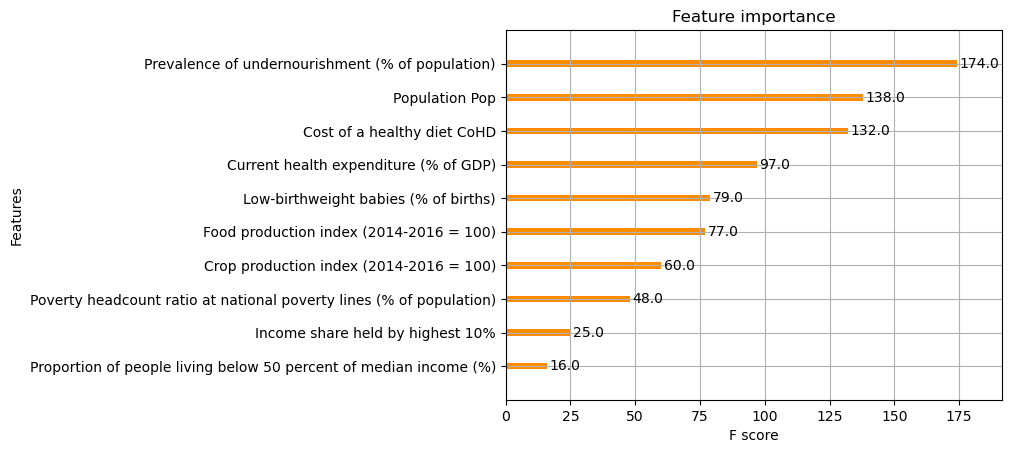

In [66]:
#now lets test feature importance: some of these features we believe were originally used to 
#calculate our target variable. After further evaluation will decide whether or not to drop these variables

xgb_classifier.fit(X_train, y_train)

# Plot feature importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(xgb_classifier, importance_type='weight', max_num_features=10, color = 'darkorange')
plt.show()

In [36]:
#here is our classification report
# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

       False       0.94      0.89      0.91        83
        True       0.85      0.91      0.88        55

    accuracy                           0.90       138
   macro avg       0.89      0.90      0.90       138
weighted avg       0.90      0.90      0.90       138



- Precision focuses on the accuracy of positive predictions.
- Recall focuses on the ability to capture all positive instances.
- F1-Score balances precision and recall, providing a single metric that considers both.
- Support provides the count of actual instances for each class.

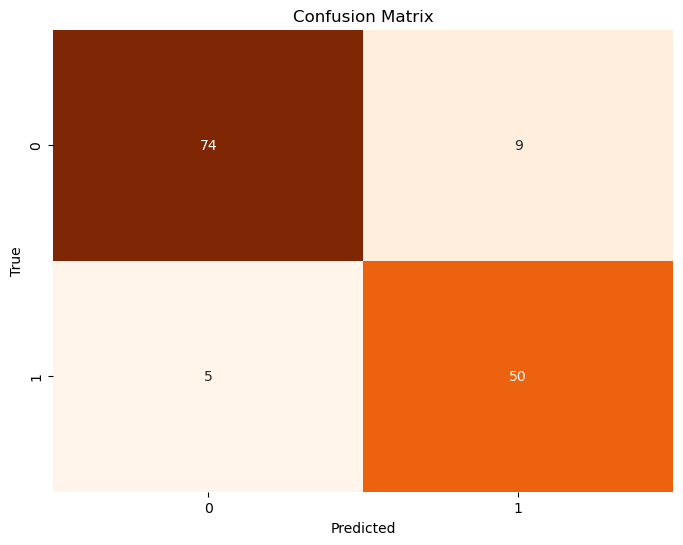

In [49]:

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

from matplotlib.colors import ListedColormap


# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

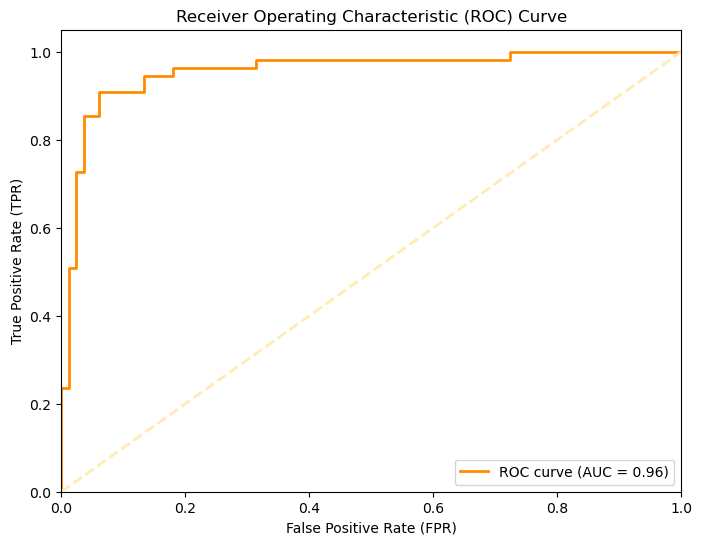

In [54]:

# Make predictions on the test set
y_scores = xgb_classifier.predict_proba(X_test)[:, 1]
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='#FFECB3', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [79]:
#Now lets make up a country to put see what our model:
# Get the minimum and maximum values for each feature
feature_ranges = X.agg(['min', 'max'])

print("Feature Ranges:")
print(feature_ranges)

num_samples = 1  
fake_data = pd.DataFrame()

# Generate random values for each feature within the derived ranges
for feature in feature_ranges.columns.get_level_values(0):
    min_val = feature_ranges.loc['min', feature]
    max_val = feature_ranges.loc['max', feature]
    random_values = np.random.uniform(min_val, max_val, num_samples)
    fake_data[feature] = random_values

fake_data.head()


fake_data.to_excel('new_country.xlsx', index=False)

Feature Ranges:
     Cost of an energy sufficient diet CoCA  \
min                                   0.239   
max                                   2.958   

     Cost of a nutrient adequate diet CoNA  Cost of a healthy diet CoHD  \
min                                  0.709                        1.822   
max                                  4.242                        7.033   

     Cost of a healthy diet relative to the cost of sufficient energy from starchy staples CoHD_CoCA  \
min                                               1.87                                                 
max                                              10.88                                                 

     Cost of fruits CoHD_f  Cost of vegetables CoHD_v  \
min                  0.162                      0.303   
max                  1.997                      1.781   

     Cost of starchy staples CoHD_ss  Cost of animal-source foods CoHD_asf  \
min                            0.147                 

In [80]:
fake_data_predictions = xgb_classifier.predict(fake_data)

if fake_data_predictions[0] == 1:
    print("The model predicts 'True'")
else:
    print("The model predicts 'False' ")
#therefore there is a high percent of the population that cannot afford a nutritional diet

The model predicts 'False' 
